In [1]:
# Dependencies
import requests
import json
import pandas as pd

from datetime import datetime
from dateutil.parser import parse

https://open.fda.gov/apis/food/enforcement/



In [2]:
# Performing a GET Request and saving the 
# API's response within a variable

with open('food.json') as json_file:
    data = json.load(json_file)


#Importing to dataframe

TotalRecall = pd.DataFrame(data['results'])

group = TotalRecall.groupby(['state'])

count = group.count()

TotalRecall

,address_1,address_2,center_classification_date,city,classification,code_info,country,distribution_pattern,event_id,initial_firm_notification,...,product_type,reason_for_recall,recall_initiation_date,recall_number,recalling_firm,report_date,state,status,termination_date,voluntary_mandated
0,748 S Alameda St,,20120926,Los Angeles,Class II,not available.,United States,California,63150,E-Mail,...,Food,M & K Trading is recalling Korean Molluscan Sh...,20120921,F-2396-2012,M & K Trading Inc,20121003,CA,Terminated,20120926,Voluntary: Firm Initiated
1,4401 Foxdale St,,20120924,Irwindale,Class I,"UPC 7774523746, Use by dates 9/8/2012 or earli...",United States,Nationwide to following US States and Canada: ...,63062,Press Release,...,Food,"Firm is voluntarily recalling, out of an abund...",20120831,F-2382-2012,Ready Pac Foods Inc,20121003,CA,Terminated,20121025,Voluntary: Firm Initiated
2,2315 Moore Ave,,20120927,Fullerton,Class II,"UPC 0-30871-33001-2, Item # 0291710.",United States,Nationwide and Canada.,62991,Letter,...,Food,The firm recalled due to a potential non-safet...,20120712,F-2438-2012,Pulmuone Wildwood Inc,20121003,CA,Terminated,20121217,Voluntary: Firm Initiated
3,2315 Moore Ave,,20120927,Fullerton,Class II,"UPC 0-52334-11659-9, Item # 0291661.",United States,Nationwide and Canada.,62991,Letter,...,Food,The firm recalled due to a potential non-safet...,20120712,F-2436-2012,Pulmuone Wildwood Inc,20121003,CA,Terminated,20121217,Voluntary: Firm Initiated
4,1720 Locust Grove Road,,20120921,Manheim,Class II,"No codes; all product ""Purchase by date shown ...",United States,Product was distributed to specific wholesale ...,62465,Telephone,...,Food,FDA samples of product tested positive for Fum...,20120417,F-2374-2012,Haldeman Mills,20121003,PA,Terminated,20130716,Voluntary: Firm Initiated
5,3919 Oceanic Dr Ste 703,,20120921,Oceanside,Class I,Batch/Lot#0030812,United States,nationwide in the US and worldwide to Canada a...,63002,Press Release,...,Food,True Nutrition is recalling Whey Protein Isola...,20120824,F-2368-2012,MyoSci Technologies Inc.,20121003,CA,Terminated,20121119,Voluntary: Firm Initiated
6,333 50th St Sw,,20120924,Wyoming,Class I,"GFS Item #866580 10015196182512, Lot 060412, ...",United States,restaurants and GFS retail outlets in Florida,63058,"Two or more of the following: Email, Fax, Lett...",...,Food,Gordon Food Service is recalling Tropical Food...,20120830,F-2390-2012,Gordon Food Service,20121003,MI,Terminated,20121204,Voluntary: Firm Initiated
7,4021B Old Philadelphia Pike,,20120928,Gordonville,Class II,All product with use by date up to and includi...,United States,Distribution within the US to PA.,63055,Telephone,...,Food,Product labeling fails to declare allergens (w...,20120828,F-2447-2012,Sadie's Salads,20121010,PA,Terminated,20131018,Voluntary: Firm Initiated
8,3400 Millington RD,"Beloit, WI 53511 USA",20121001,Beloit,Class I,Lot #O4120710,United States,The product was distributed to UT.,63084,Telephone,...,Food,The product may be contaminated with Salmonella.,20120831,F-0007-2013,Kerry Foods,20121010,WI,Terminated,20121220,Voluntary: Firm Initiated
9,4021B Old Philadelphia Pike,,20120928,Gordonville,Class I,All product with use by date up to and includi...,United States,Distribution within the US to PA.,63055,Telephone,...,Food,Product labeling fails to declare allergens (e...,20120828,F-1074-2012,Sadie's Salads,20121010,PA,Terminated,20131018,Voluntary: Firm Initiated


Analysis Goals:

1.  Calculate Recall Durations and compare to notification method, and year

2.  **Ambitious** Find keywords in product description as another grouping method

3.  Group by states and see track recall frequency changes over time

4.


AttributeError: 'AxesSubplot' object has no attribute 'ylim'

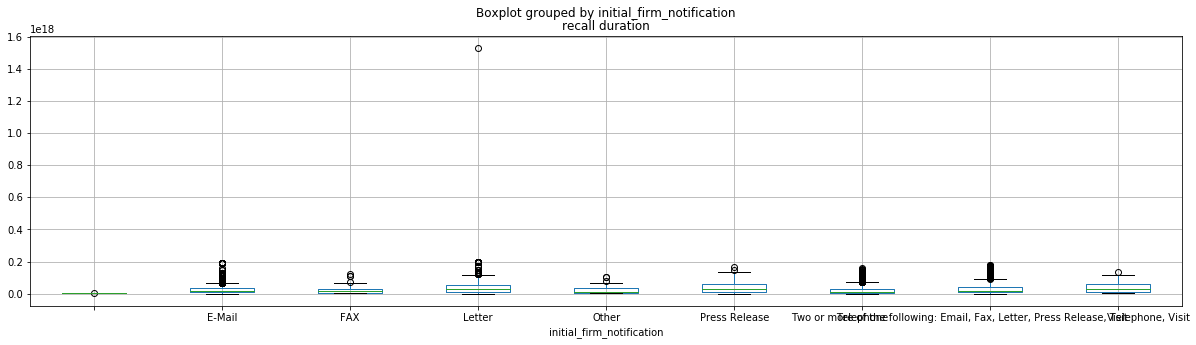

In [31]:
date1 = pd.to_datetime(TotalRecall['recall_initiation_date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
date2 = pd.to_datetime(TotalRecall['termination_date'],format= '%Y%m%d', errors='ignore').values.astype('datetime64[D]')
TotalRecall['recall duration'] = (date2 - date1)

Letter = TotalRecall[TotalRecall["initial_firm_notification"] == "Letter"]["recall duration"]
Email = TotalRecall[TotalRecall["initial_firm_notification"] == "E-Mail"]["recall duration"]
Press = TotalRecall[TotalRecall["initial_firm_notification"] == "Press Release"]["recall duration"]
Phone = TotalRecall[TotalRecall["initial_firm_notification"] == "Telephone"]["recall duration"]
Visit = TotalRecall[TotalRecall["initial_firm_notification"] == "Visit"]["recall duration"]
Other = TotalRecall[TotalRecall["initial_firm_notification"] == "Other"]["recall duration"]
Fax = TotalRecall[TotalRecall["initial_firm_notification"] == "FAX"]["recall duration"]

plt = TotalRecall.boxplot("recall duration", by="initial_firm_notification", figsize = (20,5))

plt.ylim(10, 40)